# Getting started

In [2]:
%matplotlib inline

from matplotlib_inline.backend_inline import set_matplotlib_formats

from y0.algorithm.identify import Identification, Query, Unidentifiable, identify
from y0.algorithm.identify.id_star import ConflictUnidentifiable
from y0.dsl import D, P, Variable, W, X, Y, Z
from y0.graph import NxMixedGraph

set_matplotlib_formats("svg")

# Identifiablility

Causal inference is about the ability to estimate the the probability of an event when it occurs in a different distribution than the distribution you have data for.    Identifiability algorithms can tell you when it is possible, and how to adjust the data from you have to estimate the quantity from the distribution you want.

For example the `ID` algorithm tells you when you can estimate the probability of an event that occurs in an interventional distribution when you have data that came from an observational distribution.




## Why is identifiability important?

To understand why identifiability is important, let’s consider an historical example.
In the 1950’s, advertising agencies got very good at selling cigarettes to Americans and doctors were noticing a concomitant increase in lung cancer cases.
 So they wanted to know,  can we use this data to prove that this association  is causal?
 
![Smoking](images/Smoking.png)

R.A. Fisher, the father of the randomized control trial and also an avid smoker said "No, we don’t know."  
> It could be the case that there is some unobserved gene that causes you to crave nicotine and also makes you more likely to get cancer later on in life.
In a world where a smoking gene causes cancer, then you are denying a doomed person the simple pleasure of smoking.
The only way to resolve this conundrum is to conduct an experiment where you force some people to smoke, and others not to smoke, regardless of their genetic predisposition, and then follow their lives for 30 years.
Then you will have the answer.



## Unidentifiable example

 
And unfortunately, he is right.  There is no way to estimate the causal effect of smoking on cancer from observational data if we do not know who has the smoking gene.  

![Smoking hidden genetics](images/Smoking-hidden-genetics.png)

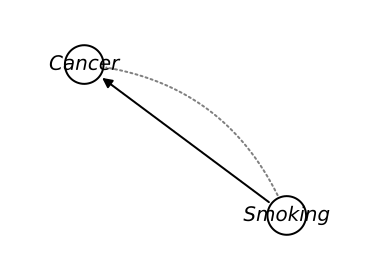

In [3]:
Smoking, Genetics, Cancer = Variable("Smoking"), Variable("Genetics"), Variable("Cancer")

unidentifiable_graph = NxMixedGraph.from_edges(
    directed=[(Smoking, Cancer)], undirected=[(Smoking, Cancer)]
)
unidentifiable_graph.draw()

In [4]:
cancer_do_smoking = Query(outcomes={Cancer}, treatments={Smoking})

try:
    identify(
        Identification(
            query=cancer_do_smoking, estimand=P(Cancer, Smoking), graph=unidentifiable_graph
        )
    )
except Unidentifiable as u:
    print("Unidentifiable: Hedge formed from", u)

Unidentifiable: Hedge formed from (NodeView((Cancer, Smoking)), {frozenset({Cancer})})


## Backdoor example

 Ah, but what if we could sequence the genome and isolate this smoking gene?  
Could we then predict the effect of smoking on cancer?
And the answer is Yes!
![Smoking observable genetics](images/Smoking-observable-genetics.png)

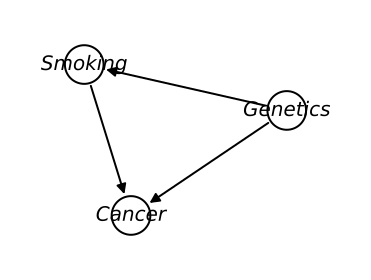

In [5]:
backdoor_graph = NxMixedGraph.from_edges(
    directed=[(Smoking, Cancer), (Genetics, Smoking), (Genetics, Cancer)]
)
backdoor_graph.draw()

In [6]:
identify(
    Identification(
        query=cancer_do_smoking, estimand=P(Cancer, Smoking, Genetics), graph=backdoor_graph
    )
)

Sum[Genetics](P(Cancer | Genetics, Smoking) * Sum[Cancer, Smoking](P(Cancer, Genetics, Smoking)))

## Front door example

 What if the smoking gene cannot be isolated,  but we have evidence that the effect of smoking on cancer is mediated by tar buildup in the lungs?
Then the answer is Yes!
You can either mutilate the model on the left and generate data from the interventional distribution directly, or 
In general, there exists a sound and complete algorithm that tells you when a causal effect can be predicted from observational data, even in the presence of confounding.
without the need for performing a randomized controlled trial 
![Smoking-with-tar](images/Smoking-with-tar.png)

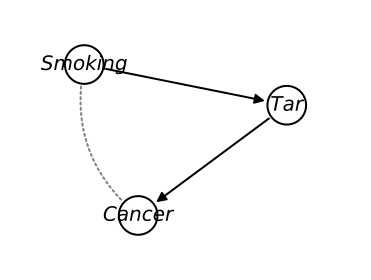

In [15]:
Tar = Variable("Tar")
front_door = NxMixedGraph.from_edges(
    directed=[(Smoking, Tar), (Tar, Cancer)], undirected=[(Smoking, Cancer)]
)
front_door.draw()

In [16]:
identify(
    Identification(query=cancer_do_smoking, estimand=P(Cancer, Tar, Smoking), graph=front_door)
)

Sum[Tar](P(Tar | Smoking) * Sum[Smoking](P(Cancer | Smoking, Tar) * P(Smoking)))

# Counterfactual Identifiability

Identifiability isn't just about estimating the effect of interventions from observational data. It is also sometimes possible to estimate a counterfactual effect from interventional data.  The `ID*` algorithm tells you when and how.

## Identifiable counterfactual example

Let's suppose you might be interested in how likely a patient would be to have symptom $Y$ given a certain dose $x$ of a drug $X$, assuming we know that the patient has taken does $x'$ of drug $X$, dose $d$ of drug $D$, and we know how an intermediate symptom $Z$ responds to treatment $d$.  This would correspond to the query $P(y_x|x', z_d, d)$, which mentions three worlds, the original model $M$, and the submodels $M_d$ and $M_x$.  

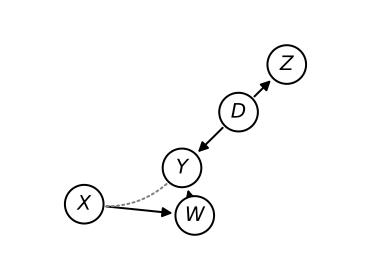

In [17]:
from y0.algorithm.identify.id_star import id_star
from y0.algorithm.identify.idc_star import idc_star

identifiable_graph = NxMixedGraph.from_edges(
    directed=[(X, W), (D, Z), (W, Y), (D, Y)], undirected=[(X, Y)]
)
identifiable_graph.draw()

In [18]:
id_star(graph=identifiable_graph, event={Y @ -X: -Y, X: +X, Z @ -D: -Z, D: -D})

Sum[W](P(D) * P[X](W) * P[D,W](X, Y) * P[D](Z))

## Unidentifiable counterfactual example: Probability of necessary and sufficient causation
An example of the probability of necessary and sufficient causation $P(Y_{do(x')}=y', Y_{do(x)}=y)$ is when a person who has cancer must make a decision as to whether she wishes to go through with chemotherapy.  If she were to survive cancer without chemotherapy, she would rather not have to go through the side effects, and if she were going to die anyway, why subject herself to unnecessary suffering?  The only reason she would choose it is if she knew that she would probably die if she didn't take chemotherapy and would survive only if she took it.  Let $Y$ be true if she survives, and $X$ be the choice to take chemotherapy.  The $P(Y_{do(x')}=y', Y_{do(x)}=y)$ is the probability that by not doing chemotherapy she would die, and by taking chemotherapy she would live.
This query turns out not to be identifiable.

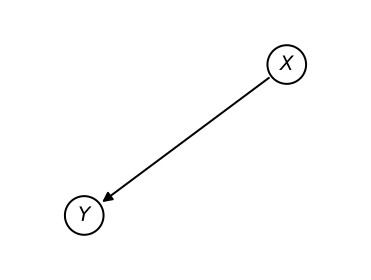

In [19]:
unidentifiable_graph = NxMixedGraph.from_edges(directed=[(X, Y)])
unidentifiable_graph.draw()

In [20]:
try:
    id_star(graph=unidentifiable_graph, event={Y @ -X: -Y, Y @ +X: +Y})
except ConflictUnidentifiable as c:
    print(
        f"ID* is unidentifiable due for counterfactual graph: \n{c.cf_graph},\n and event {c.event} due to conflicts {c.conflicts}"
    )

ID* is unidentifiable due for counterfactual graph: 
NxMixedGraph(directed=<networkx.classes.digraph.DiGraph object at 0x13eddaff0>, undirected=<networkx.classes.graph.Graph object at 0x13edda5a0>),
 and event {Y @ -X: -Y, Y @ +X: +Y} due to conflicts [(+X, -X), (-X, +X)]


## Identifiable conditional counterfactual example

We can also identify conditional counterfactuals with the `IDC*` algorithm.  Let's return to the smoking example. Suppose that $Smoking$ can cause $Cancer$ through mechanisms other than Tar, and furthermore, that there is an unobserved genetic effect that not only causes someone to crave nicotine, but also makes it harder for the body to remove tar buildups.  Given  a $Smoking$ population, can we estimate how likely quitting $Smoking$ would reduce their chances of getting $Cancer$ if we also had data from a randomized trial where it was shown that quitting $Smoking$ reduces the amount of $Tar$ buildup in the lungs?

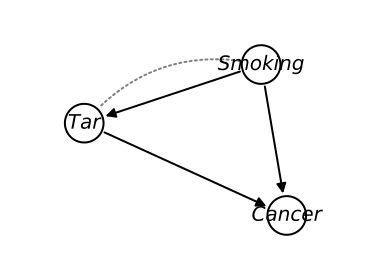

In [21]:
graph = NxMixedGraph.from_edges(
    directed=[(Smoking, Tar), (Tar, Cancer), (Smoking, Cancer)], undirected=[(Smoking, Tar)]
)
graph.draw()

In [22]:
idc_star(
    graph=graph,
    outcomes={Cancer @ -Smoking: -Cancer},
    conditions={Tar @ -Smoking: -Tar, Smoking: +Smoking},
)

P[Tar,Smoking](Cancer)